In [1]:
import torch
from diffusers import StableDiffusionPipeline

In [2]:
from PIL import Image

#Helper function to display image grid
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
MODEL_CKPT = 'runwayml/stable-diffusion-v1-5'

prompts = [
    "a photo of an astronaut riding a horse on mars",
    "A high tech solarpunk utopia in the Amazon rainforest",
    "A pikachu fine dining with a view to the Eiffel Tower",
    "A mecha robot in a favela in expressionist style",
    "an insect robot preparing a delicious meal",
    "A small cabin on top of a snowy mountain in the style of Disney, artstation",
]

pipe_config = {
    "height": 512,
    "width": 512,
    "negative prompt": "ugly, deformed",
    "num_images_per_prompt": 2,
    "num_inference_steps": 30,
    "guidance_scale": 7.5
}

def getSDPipeline():
    pipe = StableDiffusionPipeline.from_pretrained(MODEL_CKPT, torch_dtype=torch.float32)
    return pipe

In [5]:
sdPipeline = getSDPipeline()
sdPipeline.to(device)

rng = torch.Generator(device=device) #Generator for seed
seed = 1337
rng.manual_seed(seed)
gen_imgs = []

with torch.inference_mode():
    for prompt in prompts:
        images = sdPipeline(
            prompt=prompt,
            generator=rng,
            **pipe_config
        ).images
        gen_imgs.extend(images)

print('Generated images: ', len(gen_imgs))

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Generated images:  12


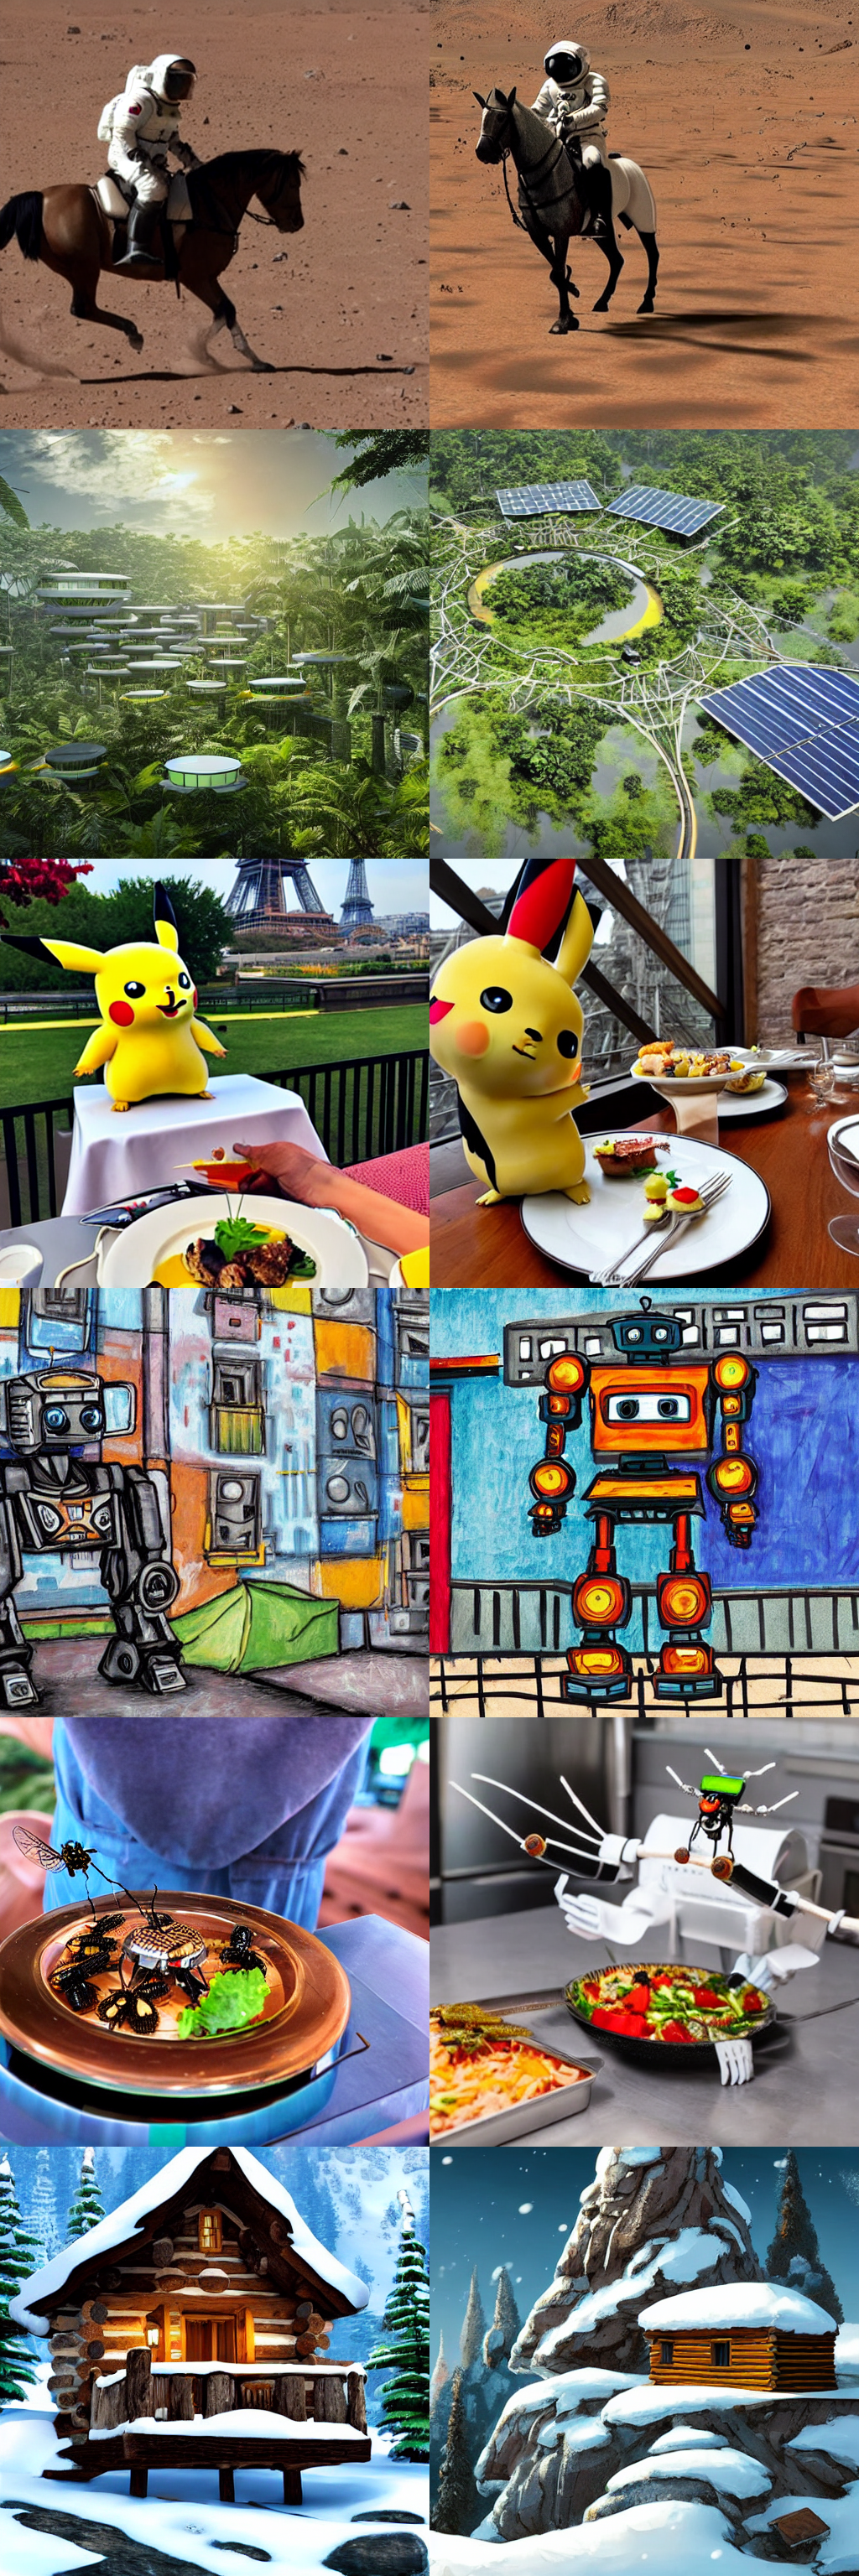

In [6]:
image_grid(gen_imgs, 6, 2)

In [7]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

In [9]:
import numpy as np

prompts = [item for item in prompts for _ in range(2)]
images_np = np.stack([np.array(img) for img in gen_imgs])
sd_clip_score = calculate_clip_score(images_np, prompts)
print(f"CLIP score: {sd_clip_score}")

CLIP score: 29.9917
